In [ ]:
import zipfile
import os
import re
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [ ]:
# ZIPファイルPATH
zippath = './1594466329_93005200_9984.zip'

dirbase = os.path.splitext(zippath)[0]

# 解凍後のファイルPATH
txtpath =  dirbase + '.txt'

# ファイル名から株価コード取得
code = dirbase[dirbase.rfind('_') + 1:]

print(txtpath)
print(code)

In [ ]:
# ZIPファイル解凍
with zipfile.ZipFile(zippath) as zf:
    zf.extractall()

In [ ]:
# 株価ファイル前処理（数値で始まる行のみを抽出）
codetsv = code + '.tsv'
with open( codetsv, mode='w') as wf:
    with open(txtpath) as rf:
        for rline in rf :
            if re.search('^[0-9]', rline):
                wf.write(rline)

In [ ]:
# 株価ファイルをデータフレームに読み込む
df_tsv = pd.read_table(codetsv, index_col=0, names=('Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'AdjClose'))
print(df_tsv.dtypes)
df_tsv.head(10)

In [ ]:
# DB接続、インポート（無ければ新規に作成）
dbname = 'STOCK.db'
conn = sqlite3.connect(dbname)
df_tsv.to_sql('T' + code, conn, if_exists = 'replace')
# Option => if_exists　: append, replace, fail
conn.close()

In [ ]:
##------------------------------
## グラフ表示関数
##------------------------------
def show_graph(code, start, end):
    dbname = 'STOCK.db'
    sql = F"""
    select Date, Open, High, Low, Close, Volume, AdjClose
      from {code}
    where Date between '{start} ' and  '{end} '
    """

    #DBから株価データを取得
    conn = sqlite3.connect(dbname)
    df = pd.read_sql(sql, conn)
    conn.close()

    # Dateカラムを日付型に変換してインデックスに指定する
    df['DateIdx'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
    df = df.set_index('DateIdx')
    
    #X軸、Y軸のデータを抽出
    date = df.index
    price= df['AdjClose']

    #移動平均取得
    span01=5
    span02=25
    span03=75
    df['sma01'] = price.rolling(window=span01).mean()
    df['sma02'] = price.rolling(window=span02).mean()
    df['sma03'] = price.rolling(window=span03).mean()

    #グラフの大きさを指定
    plt.figure(figsize=(20,10))

    #株価グラフ
    plt.subplot(2,1,1)   # 縦分割数, 横分割数, 配置位置
    plt.plot(date, price, label='Close', color='#99b898')
    plt.plot(date,df['sma01'], label='Ave 5', color='#e84a5f')
    plt.plot(date,df['sma02'], label='Ave 25', color='#ff847c')
    plt.plot(date,df['sma03'], label='Ave 75', color='#feceab')
    plt.legend()

    #出来高グラフ
    plt.subplot(2,1,2)
    plt.bar(date, df['Volume'], label='Volume', color='grey')
    plt.legend()

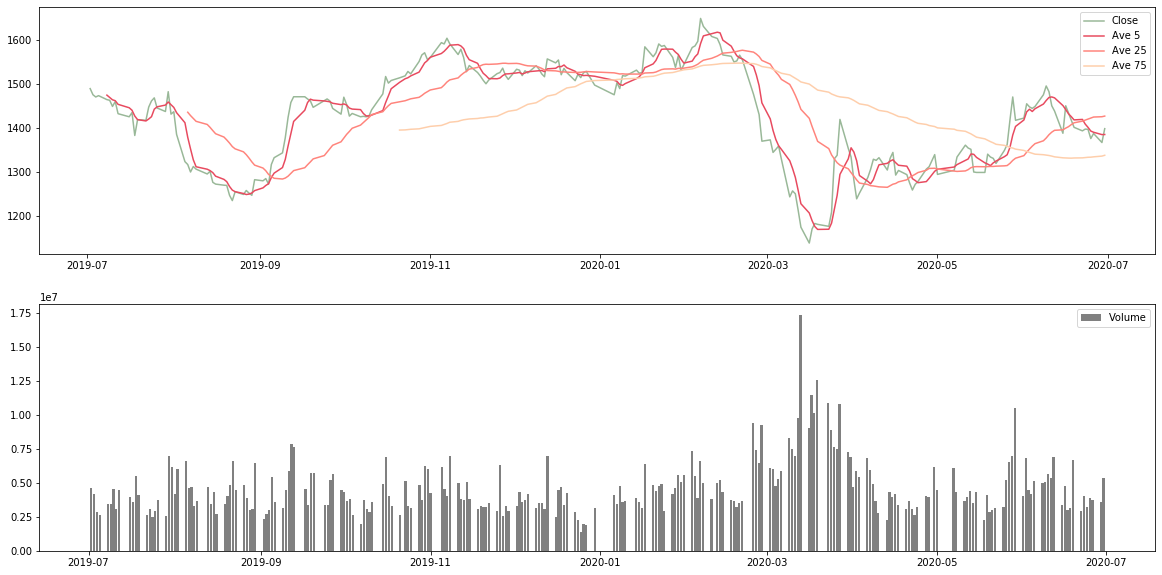

In [133]:
show_graph('T6503', '2019/07/01', '2020/07/30')